# rdag_mle: code to generate RDAGs, to sample from their distribution, and to compute MLEs

In [20]:
import numpy as np
import networkx as nx
import random

In [21]:
# setting parameters
n_vertices = 10
density = 0.5
n_colours = 5
n_samples = 100

In [22]:
# build DAG 
Gu = nx.erdos_renyi_graph(n_vertices,density)
G = nx.DiGraph()
G.add_nodes_from(Gu)
G.add_edges_from(Gu.edges())
G = G.reverse() # make edges point from higher index to lower index 

In [23]:
# assign colours (integers) to edges
for (u, v) in G.edges():
    G.edges[u,v]['colour'] = random.randint(0,n_colours-1)

In [24]:
# sample edge weights uniformly from [-1, -0.25] cup [0.25, 1]
us = np.random.uniform(-0.75,0.75,n_colours)
us[us > 0] = us[us > 0] + 0.25
us[us < 0] = us[us < 0] - 0.25
weights = us

In [25]:
# assign weights to colours
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = weights[G.edges[u,v]['colour']]
G.edges.data()

OutEdgeDataView([])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

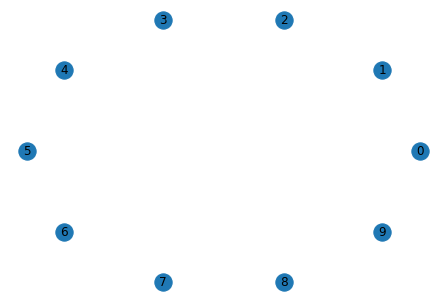

In [26]:
# plot the graph with edge labels
pos = nx.circular_layout(G) 
labels = nx.get_edge_attributes(G,'colour')
nx.draw(G, pos, with_labels = True)
nx.draw_networkx_edge_labels(G, pos, labels)
list(G)

In [27]:
# find parent relationship colours for each vertex
prc = []
for u in G.nodes():
    prcu = []
    for v in G.nodes():
        if (v,u) in G.edges():
            prcu.append(G.edges[v,u]["colour"])
    prc.append(prcu)

In [28]:
# colour the vertices so that the colouring is compatible
# assign weights to node colours 
K = nx.complete_graph(n_vertices)
H = nx.empty_graph(n_vertices)
for (u,v) in K.edges():
    if bool(set(prc[u]) & set(prc[v])):
        H.add_edge(u,v)
list_of_cc = sorted(nx.connected_components(H), key=len, reverse=True)
node_weights = np.random.uniform(0,1,len(list_of_cc))
for u in G.nodes():
    for c in range(len(list_of_cc)):
        if u in list_of_cc[c]:
            G.nodes[u]["colour"] = c
            G.nodes[u]["weight"] = node_weights[c]

In [29]:
# generate lambda and omega matrices
mat = nx.adjacency_matrix(G,range(n_vertices))
lamb = mat.todense().T
omega = np.zeros((n_vertices,n_vertices))
for i in range(n_vertices):
    omega[i,i] = G.nodes[i]["weight"]
ide = np.identity(n_vertices)
idlam = np.linalg.inv(ide-lamb)
cov1 = np.dot(idlam,omega)
cov = np.dot(cov1, idlam.T)

In [30]:
# generate sample data
sample_data = np.zeros((n_vertices,n_samples))
for i in range(n_samples):
    sample_data[:,i] = np.random.multivariate_normal(np.zeros(n_vertices),cov)
sample_data.shape

(10, 100)

In [31]:
# build augmented sample matrices, one for each vertex colour
MY0 = [];
MY = [];
betas = [];
for s in range(len(list_of_cc)):
    alpha = list_of_cc[s] # the vertices of colour s 
    alpha_vector = np.array(list(alpha))
    MYs0 = [];
    for u in alpha:
        MYs0 = np.concatenate((MYs0, sample_data[u,:]))
    MY0.append(MYs0)
    beta_multiset = [];
    for u in alpha:
        for v in G.nodes():
            if (v,u) in G.edges():
                beta_multiset.append(G.edges[v,u]['colour'])
    beta = set(beta_multiset)
    betas.append(beta)
    beta_vector = np.array(list(beta))
    MYsblocks = [];
    for u in alpha:
        MYsblock = np.zeros((len(beta),n_samples))
        for v in G.nodes():
            if (v,u) in G.edges():
                MYsblock[np.where(beta_vector == G.edges[v,u]['colour'])[0],:] += sample_data[v,:]
        MYsblocks.append(MYsblock)  
    MYs = np.zeros((len(beta),0));
    for i in range(len(alpha)):
        MYs = np.concatenate((MYs,MYsblocks[i]),axis=1)
    MY.append(MYs)

In [32]:
# compute the RDAG MLE
node_weights_hat = np.zeros(len(list_of_cc));
weights_hat = np.zeros(n_colours);
for s in range(len(list_of_cc)):
    beta = betas[s]
    beta_vector = np.array(list(beta))
    b = MY0[s];
    if MY[s].shape[0] > 0:
        A = MY[s].T;
        pinvA = np.linalg.pinv(A)
        weights_beta_s = np.dot(pinvA,b)
        weights_hat[beta_vector] = weights_beta_s
        diff = np.linalg.norm(np.dot(A,weights_beta_s)-b)**2
    else:
        diff = np.linalg.norm(b)**2
    alpha_s = len(list_of_cc[s])
    weights_alpha_s = (1/(alpha_s*n_samples))*diff
    node_weights_hat[s] = weights_alpha_s

In [40]:
# compute uncoloured DAG MLE
usual_DAG_node_weights = np.zeros(n_vertices)
usual_DAG_weights = [] 
for u in G.nodes():
    b = sample_data[u,:]
    AT = np.zeros((0,n_samples))
    for v in G.nodes():
            if (v,u) in G.edges():
                AT = np.vstack((AT, sample_data[v,:]))
    if AT.shape[0] > 0:
        A = AT.T;
        pinvA = np.linalg.pinv(A)
        weights_beta_s = np.dot(pinvA,b)
        usual_DAG_weights.append(weights_beta_s)
        diff = np.linalg.norm(np.dot(A,weights_beta_s)-b)**2
    else:
        diff = np.linalg.norm(b)**2
    usual_DAG_node_weights[u] = (1/n_samples)*diff
if usual_DAG_weights != []:
    usual_DAG_weights = np.concatenate(usual_DAG_weights)

In [17]:
# duplicate RDAG weights to compare to uncoloured DAG output
node_weights_comparable = np.zeros(n_vertices)
node_weights_hat_comparable = np.zeros(n_vertices)
for u in G.nodes():
    c = G.nodes[u]["colour"]
    node_weights_comparable[u] = node_weights[c]
    node_weights_hat_comparable[u] = node_weights_hat[c]
weights_comparable = []
weights_hat_comparable = []
for u in G.nodes():
    weights_u = []
    weights_hat_u = []
    for v in G.nodes():
        if (v,u) in G.edges():
            c = G.edges[v,u]["colour"]
            weights_u.append(weights[c])
            weights_hat_u.append(weights_hat[c])
    weights_comparable.append(weights_u)
    weights_hat_comparable.append(weights_hat_u)
weights_comparable = np.concatenate(weights_comparable)
weights_hat_comparable = np.concatenate(weights_hat_comparable)

In [19]:
# compute distance between MLE and true parameters
edge_dist_RDAG = np.linalg.norm(weights_hat_comparable - weights_comparable)**2
node_dist_RDAG = np.linalg.norm(node_weights_hat_comparable - node_weights_comparable)**2
mle_dist_RDAG = edge_dist_RDAG + node_dist_RDAG
edge_dist_DAG = np.linalg.norm(usual_DAG_weights - weights_comparable)**2
node_dist_DAG = np.linalg.norm(usual_DAG_node_weights - node_weights_comparable)**2
mle_dist_DAG = edge_dist_DAG + node_dist_DAG
[mle_dist_RDAG, mle_dist_DAG]

[0.035639765205367664, 0.5138114273748121]